In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
import math
import os

import warnings
warnings.filterwarnings('ignore')

# 自 Yahoo Finance 下載資料

In [2]:
#yahoo finance有六個欄位，Open High Low Close Adjusted-Close Volume
def get_historical_Data(ticker, start, end):
    start_date = datetime.strptime(start, '%Y-%m-%d')
    end_date = datetime.strptime(end, '%Y-%m-%d')
    data = pd.DataFrame()
    for j in range(6):
        data = pd.concat([data, pd.DataFrame(yf.download(ticker, start=start_date, 
                                                         end=end_date).iloc[:, j])], axis=1)

    return data

In [3]:
data = get_historical_Data('SPY', '1993-01-01', '2022-12-31')

data['Open_pct_change'] = (data['Open'] - data['Adj Close'].shift())/data['Adj Close'].shift().fillna(0)
data['High_pct_change'] = (data['High'] - data['Adj Close'].shift())/data['Adj Close'].shift().fillna(0)
data['Low_pct_change'] = (data['Low'] - data['Adj Close'].shift())/data['Adj Close'].shift().fillna(0)
data['Close_pct_change'] = data['Adj Close'].pct_change().fillna(0) #use adjusted close price
data['Volume_pct_change'] = data['Volume'].pct_change().fillna(0)

data = data[1:] #drop 1st row
data = data[['Open_pct_change', 'High_pct_change', 'Low_pct_change', 'Close_pct_change','Volume_pct_change']]
data.head(10)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Open_pct_change,High_pct_change,Low_pct_change,Close_pct_change,Volume_pct_change
Date,,,,,
1993-02-01,0.750186,0.761381,0.750186,0.007113,-0.521033
1993-02-02,0.747705,0.753881,0.744000,0.002118,-0.581061
1993-02-03,0.751406,0.768661,0.750173,0.010571,1.629906
1993-02-04,0.755039,0.759918,0.735525,0.004184,0.003967
1993-02-05,0.747727,0.751370,0.738010,-0.000695,-0.074130
1993-02-08,0.748941,0.755018,0.746511,0.000000,0.211339
1993-02-09,0.742865,0.742865,0.733141,-0.006949,-0.795169
1993-02-10,0.748941,0.752613,0.744046,0.001399,2.108927
1993-02-11,0.751386,0.764830,0.751386,0.004892,-0.948630


# DataFrame to Torch

In [4]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device = {device}")

Device = cpu


In [5]:
Features = torch.tensor(data.values)
Lable = torch.tensor(data['Open_pct_change'].values)

#Build rolling window of the features using unfold+flatten
X = Features.unfold(0, 7, 1).flatten(start_dim=1)[:-1].to(torch.float32).to(device)# [:-1] is to drop the last row
y = Lable[7:].to(torch.float32).to(device)

print(f'Shape of the Features: {X.shape}, Shape of the Labels: {y.shape}')

Shape of the Features: torch.Size([7528, 35]), Shape of the Labels: torch.Size([7528])


In [6]:
X[0]

tensor([ 7.5019e-01,  7.4771e-01,  7.5141e-01,  7.5504e-01,  7.4773e-01,
         7.4894e-01,  7.4286e-01,  7.6138e-01,  7.5388e-01,  7.6866e-01,
         7.5992e-01,  7.5137e-01,  7.5502e-01,  7.4286e-01,  7.5019e-01,
         7.4400e-01,  7.5017e-01,  7.3553e-01,  7.3801e-01,  7.4651e-01,
         7.3314e-01,  7.1132e-03,  2.1183e-03,  1.0571e-02,  4.1840e-03,
        -6.9467e-04,  0.0000e+00, -6.9491e-03, -5.2103e-01, -5.8106e-01,
         1.6299e+00,  3.9668e-03, -7.4130e-02,  2.1134e-01, -7.9517e-01])

In [7]:
y[0]

tensor(0.7489)

# Split Data

In [8]:
X.shape, y.shape

(torch.Size([7528, 35]), torch.Size([7528]))

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_rem, y_train, y_rem = train_test_split(X, y, 
                                                  test_size=0.3,
                                                  random_state=42) # make the random split reproducible
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, 
                                                  test_size=0.5,
                                                  random_state=42)
#70% Train, 15% Valid, 15% Test

len(X_train), len(X_valid),len(X_test), len(y_train), len(y_valid), len(y_test)

(5269, 1129, 1130, 5269, 1129, 1130)

# Data Loader

In [10]:
from torch.utils.data import TensorDataset, DataLoader

#Put Features and Labels Together
train_data = TensorDataset(X_train, y_train)
valid_data = TensorDataset(X_valid, y_valid)
test_data = TensorDataset(X_test, y_test)

# Setup the batch size hyperparameter
BATCH_SIZE = 64
# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    shuffle=True # shuffle data every epoch?
)

valid_dataloader = DataLoader(valid_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [11]:
#Check the first batch in our training data
torch.manual_seed(42)
first_batch = next(iter(train_dataloader))[0]

first_batch, first_batch.shape

(tensor([[ 0.0785,  0.0973,  0.0756,  ..., -0.2114, -0.0595, -0.1977],
         [ 0.4886,  0.4815,  0.4772,  ...,  0.1367, -0.1661, -0.1086],
         [ 0.7332,  0.7343,  0.7238,  ..., -0.4624,  2.6998, -0.7123],
         ...,
         [ 0.4348,  0.4400,  0.4370,  ...,  0.1015,  0.1985, -0.1014],
         [ 0.2232,  0.2416,  0.2446,  ...,  0.4201, -0.3294,  0.2584],
         [ 0.6191,  0.6114,  0.6172,  ..., -0.4674, -0.2044,  0.3582]]),
 torch.Size([64, 35]))

# Build the Model

In [12]:
import torch.nn as nn

class GetLSTMOutput(nn.Module): #To Ignore the second output of LSTM Layer
    def forward(self, x):
        out, _ = x
        return out

class CNNBiLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.BatchNorm1d(num_features = 1),
            ##CNN Layers##
            #input shape (64, 35), 64:batch_size, 35: 5 features * 7 days
            
            nn.Conv1d(in_channels = 1, out_channels = 64, kernel_size = 7, stride = 7),
            #(64, 35) -> (64, 64, 5)
            
            nn.ReLU(),
            nn.MaxPool1d(kernel_size = 2, stride = 1),
            #(64, 64, 5) -> (64, 64, 4)
            
            nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
            #(64, 64, 4) -> (64, 32, 4)
            
            nn.ReLU(),
            nn.MaxPool1d(kernel_size = 2),
            #(64, 32, 4) -> (64, 32, 2)
            
            nn.Flatten(),
            #(64, 32, 2) -> (64, 64) where the 64 on dim 0 is the batch_size
            
            ##BiLSTM Layers##
            
            nn.LSTM(input_size=64, hidden_size=64, bidirectional=True, batch_first=True),
            GetLSTMOutput(),
            nn.ReLU(),
            nn.LSTM(input_size=128, hidden_size=32, bidirectional=True, batch_first=True),
            GetLSTMOutput(),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
    def forward(self, x):
        x = x.unsqueeze(1) #fit the shape
        x = self.layers(x) #pass through CNN Layers
        return x.squeeze()
    
model_0 = CNNBiLSTM() #create an instance

In [13]:
from torchinfo import summary
summary(model_0, input_size=[64, 35]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
CNNBiLSTM                                [64]                      --
├─Sequential: 1-1                        [64, 1]                   --
│    └─BatchNorm1d: 2-1                  [64, 1, 35]               2
│    └─Conv1d: 2-2                       [64, 64, 5]               512
│    └─ReLU: 2-3                         [64, 64, 5]               --
│    └─MaxPool1d: 2-4                    [64, 64, 4]               --
│    └─Conv1d: 2-5                       [64, 32, 4]               6,176
│    └─ReLU: 2-6                         [64, 32, 4]               --
│    └─MaxPool1d: 2-7                    [64, 32, 2]               --
│    └─Flatten: 2-8                      [64, 64]                  --
│    └─LSTM: 2-9                         [64, 128]                 66,560
│    └─GetLSTMOutput: 2-10               [64, 128]                 --
│    └─ReLU: 2-11                        [64, 128]                 --
│    └─L

# Training Loop, Loss Function and Optimizer

In [14]:
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [15]:
model = CNNBiLSTM().to(device)
loss_fn = nn.HuberLoss(reduction = 'mean', delta = 1.0) #The Loss Function to train model
mse_loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.001 , amsgrad=True)

In [16]:
from tqdm.auto import tqdm

torch.manual_seed(42)
train_time_start_on_cpu = timer()

epochs = 100
model = CNNBiLSTM().to(device)

best_loss = math.inf

if not os.path.isdir('./models'):
    os.mkdir('./models') # Create directory of saving models.
    
model_save_path = './models/model.ckpt'

# Create training and validating loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss = 0
    train_mse = 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model.train() 
        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch
        train_mse += mse_loss(y_pred, y)

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 40 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)
    train_mse /= len(train_dataloader)
    
    ### Validating
    # Setup variables for accumulatively adding up loss and accuracy 
    valid_loss = 0 
    valid_mse = 0
    model.eval()
    with torch.inference_mode():
        for X, y in valid_dataloader:
            # 1. Forward pass
            valid_pred = model(X)
           
            # 2. Calculate loss (accumatively)
            valid_loss += loss_fn(valid_pred, y) # accumulatively add up the loss per epoch
            valid_mse += mse_loss(valid_pred, y)
        
        # Calculations on valid metrics need to happen inside torch.inference_mode()
        # Divide total valid loss by length of valid dataloader (per batch)
        valid_loss /= len(valid_dataloader)
        valid_mse /= len(valid_dataloader)

        if valid_loss < best_loss:
            best_loss = valid_loss
            torch.save(model.state_dict(), model_save_path) # Save your best model
            print('Saving model with loss {:.3f}...'.format(best_loss))
    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Train mse: {train_mse:.5f} | Valid loss: {valid_loss:.5f} | Valid mse: {valid_mse:.5f}")

# Calculate training time      
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu, 
                                           end=train_time_end_on_cpu,
                                           device=str(next(model_0.parameters()).device))

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/5269 samples
Looked at 2560/5269 samples
Looked at 5120/5269 samples
Saving model with loss 0.121...

Train loss: 0.11795 | Train mse: 0.23590 | Valid loss: 0.12112 | Valid mse: 0.24225
Epoch: 1
-------
Looked at 0/5269 samples
Looked at 2560/5269 samples
Looked at 5120/5269 samples
Saving model with loss 0.121...

Train loss: 0.11803 | Train mse: 0.23606 | Valid loss: 0.12076 | Valid mse: 0.24152
Epoch: 2
-------
Looked at 0/5269 samples
Looked at 2560/5269 samples
Looked at 5120/5269 samples
Saving model with loss 0.120...

Train loss: 0.11815 | Train mse: 0.23630 | Valid loss: 0.12049 | Valid mse: 0.24097
Epoch: 3
-------
Looked at 0/5269 samples
Looked at 2560/5269 samples
Looked at 5120/5269 samples
Saving model with loss 0.120...

Train loss: 0.11786 | Train mse: 0.23572 | Valid loss: 0.12015 | Valid mse: 0.24031
Epoch: 4
-------
Looked at 0/5269 samples
Looked at 2560/5269 samples
Looked at 5120/5269 samples

Train loss: 0.11819 | Train mse: 0.23637 

# Test Set

In [17]:
#Load Trained Model
model_test = CNNBiLSTM().to(device)
model_test.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

In [18]:
#Check the Test Set
X_test.shape, y_test.shape

(torch.Size([1130, 35]), torch.Size([1130]))

In [19]:
model_test.eval()
with torch.inference_mode():
    test_pred = model_test(X_test)
    print(f'The MSE Loss on Test Set is: {mse_loss(test_pred, y_test)}')

The MSE Loss on Test Set is: 0.24560736119747162


In [20]:
pd.DataFrame(test_pred).rename(columns = {0 : 'pred'})
pd.DataFrame(y_test).rename(columns = {0 : 'real'})
df = pd.concat([pd.DataFrame(test_pred).rename(columns = {0 : 'pred'}),
                pd.DataFrame(y_test).rename(columns = {0 : 'real'})],
                axis = 1)
df

,pred,real
0,-0.098429,0.045009
1,-0.097440,0.062112
2,-0.096896,0.553900
3,-0.096304,0.407399
4,-0.096385,0.116513
...,...,...
1125,-0.098368,0.004340
1126,-0.097561,0.367939
1127,-0.094988,0.360005
1128,-0.091011,0.660597


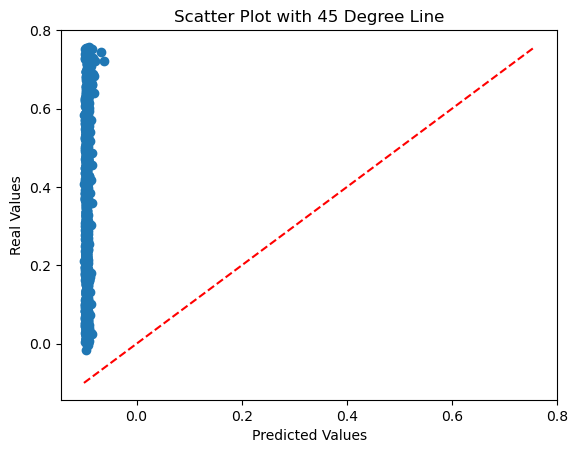

In [21]:
import matplotlib.pyplot as plt
pred = df['pred'].values
real = df['real'].values
plt.scatter(pred, real)

# Add 45 degree line
x = np.linspace(min(pred.min(), real.min()), max(pred.max(), real.max()), 100)
plt.plot(x, x, color='red', linestyle='--')

# Add labels and title
plt.xlabel('Predicted Values')
plt.ylabel('Real Values')
plt.title('Scatter Plot with 45 Degree Line')

# Show plot
plt.show()

In [22]:
pred.mean(), pred.std(), real.mean(), real.std()

(-0.09503292, 0.0026163564, 0.3509364, 0.21658629)

# 結論

使用過往七日OHLC變化率加上成交量變化率作為輸入，透過CNN-BiLSTM模型預測隔日的開盤價變動率，在Test Set上的MSE Loss表現與Train Set, Valid Set差不多。

但繪圖之後我們能發現，該模型的預測能力很差，判斷為Underfit，故之後會加入多個資產的資料進行訓練。